In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

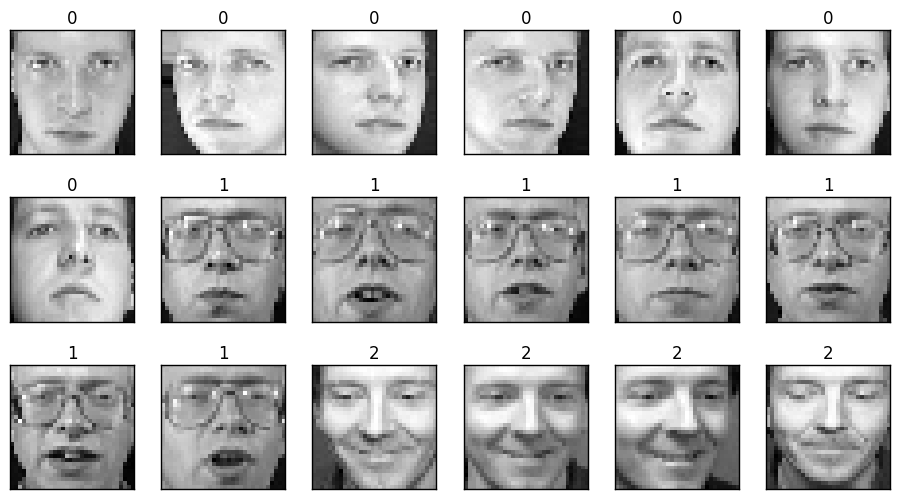

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [7]:
# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.8916666666666667


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [8]:
X_train.shape

(280, 1024)

In [9]:
X_train.mean(axis=0).shape

(1024,)

In [10]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
X_train_processed = X_train * 1.
mean = X_train_processed.mean(axis=0)
X_train_processed -= mean
std = X_train_processed.std(axis=0)
X_train_processed /= std
X_test_processed = X_test * 1.
X_test_processed -= mean
X_test_processed /= std

In [11]:
X_train_processed.shape

(280, 1024)

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [12]:
from sklearn.decomposition import RandomizedPCA

In [13]:
n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.
pca = RandomizedPCA(copy=True, n_components=n_components, random_state=123)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


We plot a bunch of principal components.

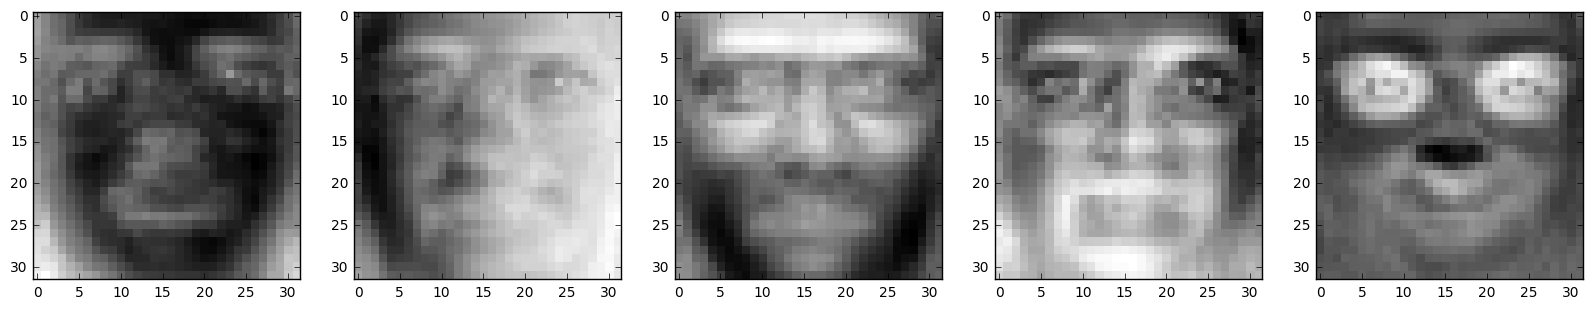

In [14]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(pca.components_[i].reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')

Transform training data, train an SVM and apply it to the encoded test data.

In [15]:
from sklearn.svm import SVC

In [16]:
svc = SVC(kernel='linear', random_state=123)

In [22]:
# Populate 'test_score' with test accuracy of an SVM classifier.
svc.fit(X_train_pca, y_train)
test_score = svc.score(X_test_pca, y_test)
print('Test score: {}'.format(test_score))

Test score: 0.95


How many components are sufficient to reach the same accuracy level?

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new imple

Max accuracy: 0.95


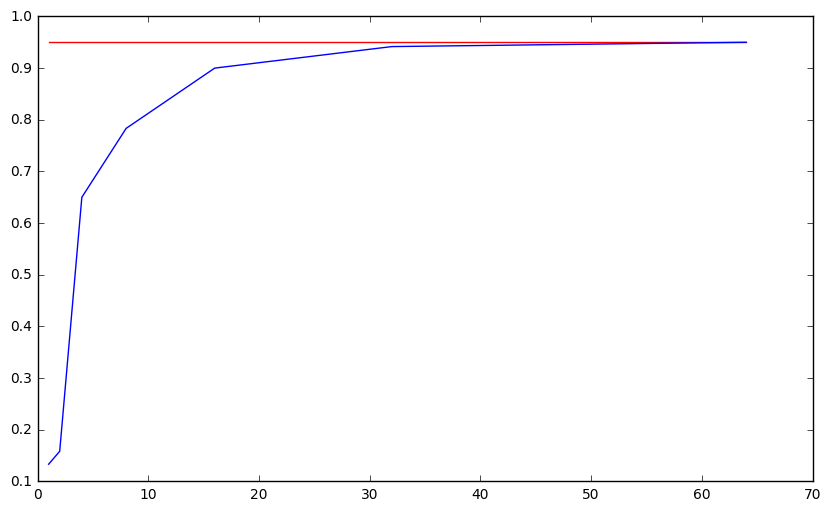

In [23]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.
for n_comp in n_components:
    pca = RandomizedPCA(n_components=n_comp, copy=True, random_state=123)
    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)
    svc.fit(X_train_pca, y_train)
    accuracy.append(svc.score(X_test_pca, y_test))
plt.figure(figsize=(10, 6))
plt.plot(n_components, test_score * np.ones(len(n_components)), 'r')
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))

как видим, в приципе достаточно 32-х компонент (для линейного ядра) 